## Setup and Imports

This section includes all necessary imports and initial setup configurations for the analysis.


In [95]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.interpolate import CubicSpline
from scipy.integrate import trapz


## Load Data

Load the standardized data from a CSV file into separate DataFrames for each category.


In [96]:


# Load the complete standardized data
df_complete = pd.read_csv('standardized_data.csv')

# List of categories to create separate DataFrames for
categories = ['Tanks', 'Aircraft', 'Artillery', 'AirDefense', 'Vehicles', 'Personnel']
df_complete['Date'] = pd.to_datetime(df_complete['Date'])

# Dictionary to hold the DataFrames for each category
category_dfs = {}

for category in categories:
    # Assuming the columns are named like 'RUS-Tanks-Documented' and 'RUS-Tanks-Claimed-UKR'
    category_columns = [col for col in df_complete.columns if category in col] + ['Date']
    category_dfs[category] = df_complete[category_columns].copy()

    # Display the first few rows of each category DataFrame
    print(f"DataFrame for {category}:")
    print(category_dfs[category].head(), '\n')

DataFrame for Tanks:
   RUS-Tanks-Documented  RUS-Tanks-Claimed-UKR       Date
0                     1                    0.0 2022-02-24
1                     2                    0.0 2022-02-25
2                     7                    0.0 2022-02-26
3                     9                  150.0 2022-02-27
4                    41                  191.0 2022-02-28 

DataFrame for Aircraft:
   RUS-Aircraft-Documented  RUS-Aircraft-Claimed-UKR       Date
0                        4                      13.0 2022-02-24
1                        5                      17.0 2022-02-25
2                        5                      34.0 2022-02-26
3                        6                      55.0 2022-02-27
4                        7                      61.0 2022-02-28 

DataFrame for Artillery:
   RUS-Artillery-Documented  RUS-Artillery-Claimed-UKR       Date
0                         0                        0.0 2022-02-24
1                         4                        0.0 2022-02

In [97]:
def clean_data(df, category):
    """Cleans data for the specified category of losses within the given DataFrame by removing rows with missing values.
    
    Args:
        df (DataFrame): The DataFrame to clean.
        category (str): The category to clean, e.g., 'Tanks', 'Aircraft'.
    """
    documented_col = f'RUS-{category}-Documented'
    claimed_col = f'RUS-{category}-Claimed-UKR'

    # Check for missing values and report them
    initial_missing = df[[documented_col, claimed_col]].isnull().sum()
    print(f"Initial missing values for {category}:")
    print(initial_missing)

    # Drop rows with missing values in either documented or claimed columns
    before_drop = len(df)
    df.dropna(subset=[documented_col, claimed_col], inplace=True)
    after_drop = len(df)

    # Convert data types to integer
    df[documented_col] = df[documented_col].astype(int)
    df[claimed_col] = df[claimed_col].astype(int)

    # Verify changes and report how many rows were dropped
    print(f"Dropped {before_drop - after_drop} rows due to missing data in {category}.")
    print(f"Data types after conversion for {category}:")
    print(df[[documented_col, claimed_col]].dtypes)
    print("\nSample data after cleaning:")
    print(df[[documented_col, claimed_col]].head())

# Apply the cleaning function to each category-specific DataFrame
for category, df in category_dfs.items():
    clean_data(df, category)


Initial missing values for Tanks:
RUS-Tanks-Documented      0
RUS-Tanks-Claimed-UKR    15
dtype: int64
Dropped 15 rows due to missing data in Tanks.
Data types after conversion for Tanks:
RUS-Tanks-Documented     int64
RUS-Tanks-Claimed-UKR    int64
dtype: object

Sample data after cleaning:
   RUS-Tanks-Documented  RUS-Tanks-Claimed-UKR
0                     1                      0
1                     2                      0
2                     7                      0
3                     9                    150
4                    41                    191
Initial missing values for Aircraft:
RUS-Aircraft-Documented      0
RUS-Aircraft-Claimed-UKR    15
dtype: int64
Dropped 15 rows due to missing data in Aircraft.
Data types after conversion for Aircraft:
RUS-Aircraft-Documented     int64
RUS-Aircraft-Claimed-UKR    int64
dtype: object

Sample data after cleaning:
   RUS-Aircraft-Documented  RUS-Aircraft-Claimed-UKR
0                        4                        13
1    

## Numerical Differentiation Using Finite Differences

This function uses central finite differences to compute the derivative, a suitable choice for uniformly spaced data. By calculating the derivative for both the documented and claimed columns, this method directly compares the rate at which each set of data changes.


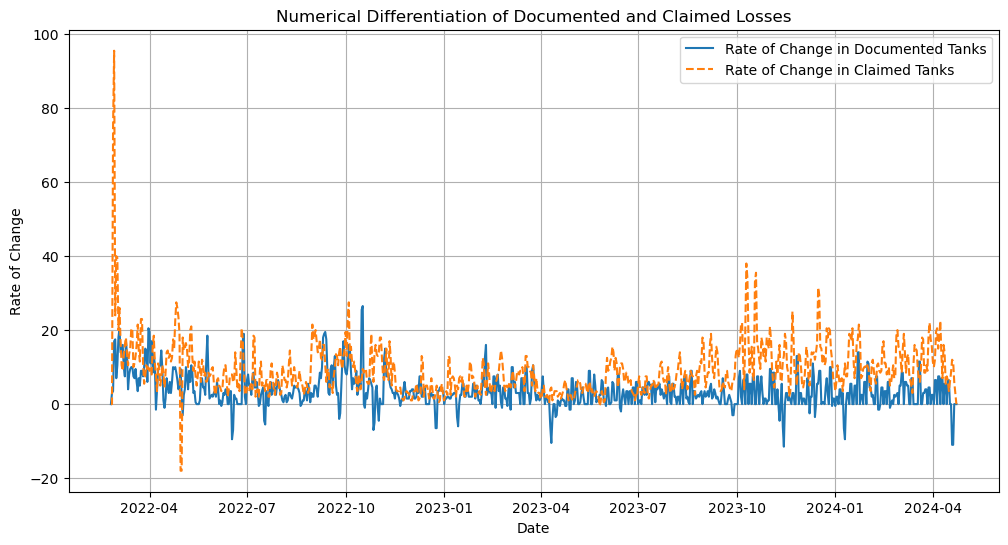

In [98]:
def numerical_differentiation(df, column):
    derivatives = np.zeros(len(df))
    for i in range(1, len(df)-1):
        derivatives[i] = (df[column].iloc[i+1] - df[column].iloc[i-1]) / 2
    return derivatives

def plot_derivatives(df, category):
    documented_col = f'RUS-{category}-Documented'
    claimed_col = f'RUS-{category}-Claimed-UKR'

    # Calculate derivatives
    doc_derivatives = numerical_differentiation(df, documented_col)
    claim_derivatives = numerical_differentiation(df, claimed_col)

    # Plotting
    plt.figure(figsize=(12, 6))

    plt.plot(df['Date'], doc_derivatives, label=f'Rate of Change in Documented {category}')
    plt.plot(df['Date'], claim_derivatives, label=f'Rate of Change in Claimed {category}', linestyle='--')
    plt.title('Numerical Differentiation of Documented and Claimed Losses')
    plt.xlabel('Date')
    plt.ylabel('Rate of Change')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_derivatives(category_dfs['Tanks'], 'Tanks')

## Cubic Spline Interpolation and Numerical Integration

Apply cubic spline interpolation to both the documented and claimed data, followed by numerical integration using the trapezoidal rule. This analysis aims to smooth the data for better visualization and quantify the total discrepancies over time.


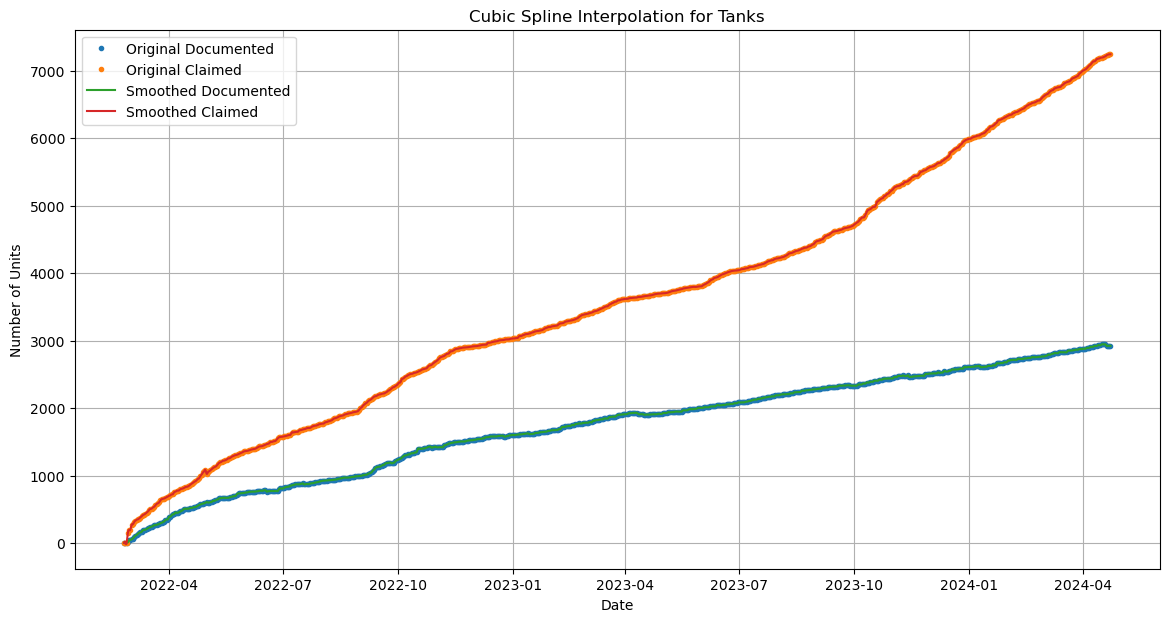

Total Integrated Documented Losses: 1372196.3602759833
Total Integrated Claimed Losses: 2839145.009639313
Integrated Discrepancy: -1466948.6493633296


In [99]:

def apply_cubic_spline_interpolation(df, category):
    documented_col = f'RUS-{category}-Documented'
    claimed_col = f'RUS-{category}-Claimed-UKR'
    cs_documented = CubicSpline(np.arange(len(df)), df[documented_col])
    cs_claimed = CubicSpline(np.arange(len(df)), df[claimed_col])

    x_new = np.linspace(0, len(df) - 1, len(df)*10)  # Increased resolution
    y_smoothed_documented = cs_documented(x_new)
    y_smoothed_claimed = cs_claimed(x_new)

    # Create a new date range with increased resolution
    date_range = pd.date_range(start=df['Date'].iloc[0], end=df['Date'].iloc[-1], periods=len(x_new))

    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df[documented_col], 'o', label='Original Documented', markersize=3)
    plt.plot(df['Date'], df[claimed_col], 'o', label='Original Claimed', markersize=3)
    plt.plot(date_range, y_smoothed_documented, label='Smoothed Documented')
    plt.plot(date_range, y_smoothed_claimed, label='Smoothed Claimed')
    plt.title(f'Cubic Spline Interpolation for {category}')
    plt.xlabel('Date')
    plt.ylabel('Number of Units')
    plt.legend()
    plt.grid(True)
    plt.show()

    return x_new, y_smoothed_documented, y_smoothed_claimed


x_new, y_smoothed_documented, y_smoothed_claimed = apply_cubic_spline_interpolation(category_dfs['Tanks'], 'Tanks')
def integrate_smoothed_data(x_new, y_smoothed_documented, y_smoothed_claimed):
    total_documented = trapz(y_smoothed_documented, x_new)
    total_claimed = trapz(y_smoothed_claimed, x_new)

    print(f"Total Integrated Documented Losses: {total_documented}")
    print(f"Total Integrated Claimed Losses: {total_claimed}")

    discrepancy = total_documented - total_claimed
    print(f"Integrated Discrepancy: {discrepancy}")

integrate_smoothed_data(x_new, y_smoothed_documented, y_smoothed_claimed)

In [100]:
def compute_errors(df, documented_col, claimed_col):
    mae = mean_absolute_error(df[documented_col], df[claimed_col])
    mse = mean_squared_error(df[documented_col], df[claimed_col])
    print(f"Mean Absolute Error: {mae}, Mean Squared Error: {mse}")
    
compute_errors(category_dfs['Tanks'], 'RUS-Tanks-Documented', 'RUS-Tanks-Claimed-UKR')


Mean Absolute Error: 1859.6443037974684, Mean Squared Error: 4653044.879746836


## Linear Regression Analysis

This section performs linear regression to assess the relationship between documented and claimed losses. The slope and intercept from the regression can indicate systematic bias—if the slope significantly differs from 1 or the intercept is not close to 0, it might suggest over- or under-reporting. The R-squared value shows the strength of the correlation between the datasets.


Regression slope: 2.36
Regression intercept: -506.74
R-squared value: 0.97


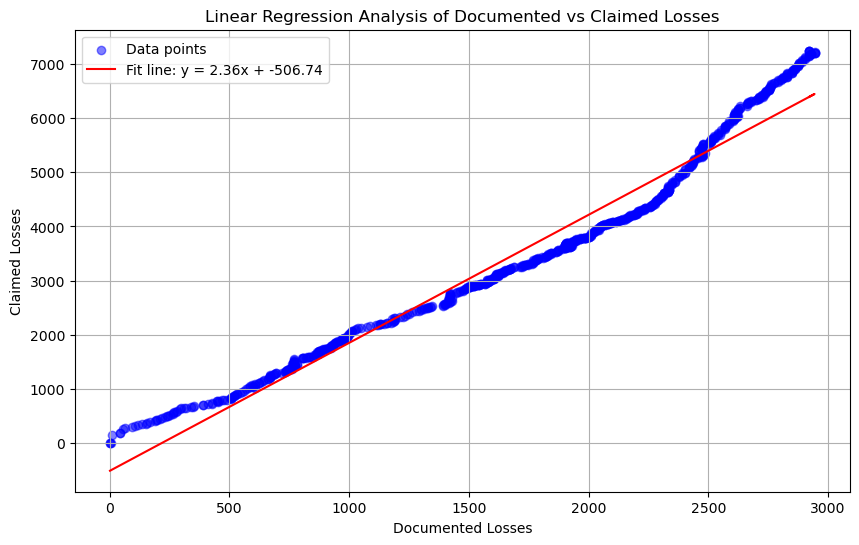

In [101]:
from scipy.stats import linregress

def linear_regression_analysis(df, documented_col, claimed_col):
    # Perform linear regression
    slope, intercept, r_value, _, _ = linregress(df[documented_col], df[claimed_col])

    # Print regression results
    print(f"Regression slope: {slope:.2f}")
    print(f"Regression intercept: {intercept:.2f}")
    print(f"R-squared value: {r_value**2:.2f}")

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.scatter(df[documented_col], df[claimed_col], color='blue', alpha=0.5, label='Data points')
    plt.plot(df[documented_col], intercept + slope * df[documented_col], 'r-', label=f'Fit line: y = {slope:.2f}x + {intercept:.2f}')
    plt.title('Linear Regression Analysis of Documented vs Claimed Losses')
    plt.xlabel('Documented Losses')
    plt.ylabel('Claimed Losses')
    plt.legend()
    plt.grid(True)
    plt.show()
linear_regression_analysis(category_dfs['Tanks'], 'RUS-Tanks-Documented', 'RUS-Tanks-Claimed-UKR')


## Execute Comprehensive Analysis

Select a category and execute all defined analysis methods for that category.


Mean Absolute Error: 1859.6443037974684, Mean Squared Error: 4653044.879746836


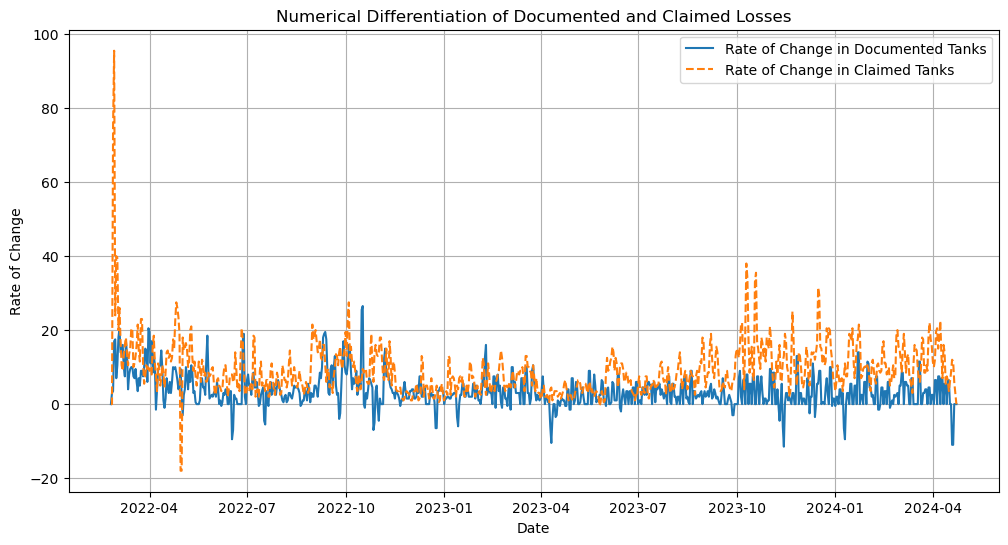

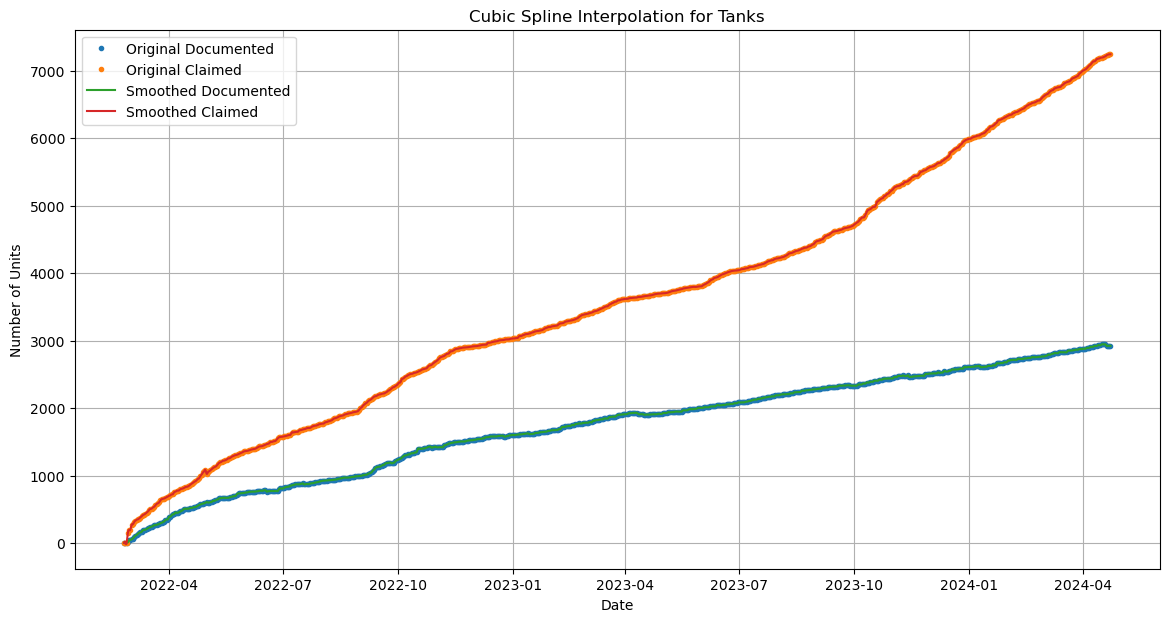

Total Integrated Documented Losses: 1372196.3602759833
Total Integrated Claimed Losses: 2839145.009639313
Integrated Discrepancy: -1466948.6493633296
Regression slope: 2.36
Regression intercept: -506.74
R-squared value: 0.97


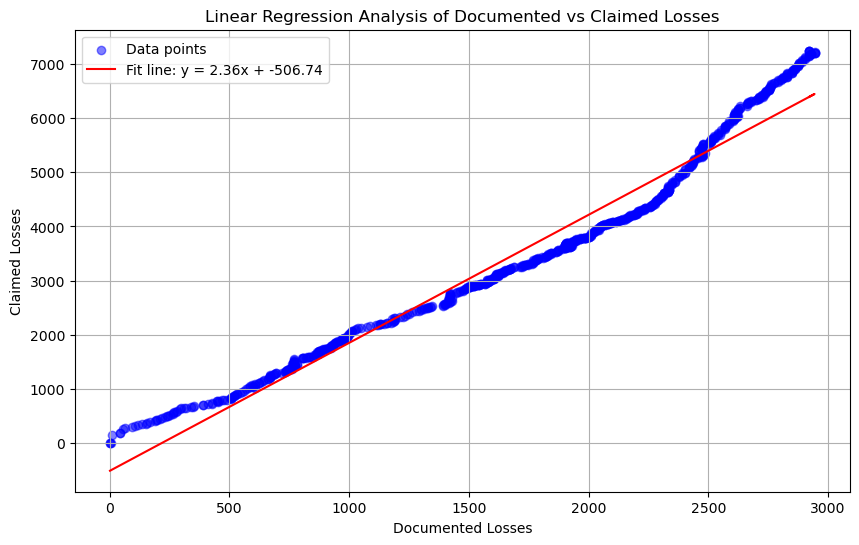

In [102]:
selected_category = 'Tanks'  # User can change this as needed
category_df = category_dfs[selected_category]
documented_col = f'RUS-{selected_category}-Documented'
claimed_col = f'RUS-{selected_category}-Claimed-UKR'

# Perform error metrics calculation
compute_errors(category_df, documented_col, claimed_col)

# Perform numerical differentiation and plot
plot_derivatives(category_df, selected_category)

# Apply cubic spline interpolation and capture the new x values and smoothed y values
x_new, y_smoothed_documented, y_smoothed_claimed = apply_cubic_spline_interpolation(category_df, selected_category)

# Perform numerical integration on the smoothed data
integrate_smoothed_data(x_new, y_smoothed_documented, y_smoothed_claimed)

# Perform and plot linear regression analysis
linear_regression_analysis(category_df, documented_col, claimed_col)
